In [1]:
import numpy as np
import pagn.constants as ct
import matplotlib.pyplot as plt
import pagn

import NT_disk_Eqns_V1 as jscript

#some nicer code based on Test_zone.ipynb

In [61]:
G=ct.G
c=ct.c
MSun=ct.MSun

def rho_NT(r, MBH, spin, mdot, alpha):
    M=MBH * G /(c*c)
    m=MBH/MSun
    rstar=(r/M)
    y=np.sqrt(r/M)

    A=jscript.A_fn(y, spin)
    B=jscript.B_fn(y, spin)
    D=jscript.D_fn(y, spin)
    E=jscript.E_fn(y, spin)
    Q=jscript.Q_fn(y, MBH, spin)

    rho_0 = 2e-5 * alpha**(-1) * m**(-1) * mdot**(-2) * rstar**(3/2) * A**(-4) * B**6 * D * E*E * Q**(-2)
    return(rho_0)

In [ ]:
MBH_power=8

MBH=10**MBH_power * ct.MSun #in kgs
spin=0.9
alpha=0.1
eps=0.1
mdot=0.1 #in terms of Ledd

le=0.01
eps = 0.1

Rsch= 2*ct.G*MBH/ct.c**2

X=0.7
b=0
Opacity='combined'

#general scaling from Abramowicz and Fragile
M=MBH * ct.G /(ct.c*ct.c)
m=MBH/ct.MSun

R_G=ct.G*MBH*(1/(ct.c*ct.c))

# print(f'R_G = {R_G} m')

Rmin= jscript.R_isco_function(MBH, spin) #uses relativistic eqn for ISCO to set inner edge of disc
Rmax=1e4*R_G #for the sake of this quick maths it doesn't really matter what this is as long as its large 

r_isco=jscript.R_isco_function(MBH, spin)

R=np.linspace(r_isco, Rmax, 1000000) 

Rs=[]
Rs_mid=[]

R_full=[]

Fs=[]
sigmas=[]
sigmas_nospin=[]
sigmas_mid=[]

Hs=[]
hs=[]
rho0s=[]

Ts=[]
Ts_mid=[]

betas=[]
taus=[]

flag=0
flag2=0
flag3=0

r_tr=0
r_rel=0
r_outer=0

for i in range(1,1000000):
    r=R[i]
    y=np.sqrt(r/M)
    rstar=(r/M)

    R_tr=jscript.R_tr(y, MBH, spin, eps, le, alpha)

    rho_0=jscript.rho_NT(r, MBH, spin, mdot, alpha)
    H=jscript.H_NT(r, MBH, spin, mdot)
    sigma=jscript.Sigma_NT(r, MBH, spin, mdot, alpha)

    rho=sigma/(2*H)

    if R_tr/r>=0.5:
        
        T=jscript.T_NT(r, MBH, spin, mdot, alpha)
        Rs.append(rstar)
        sigmas.append(sigma)
        Ts.append(T)

    omega=np.sqrt(ct.G * MBH / (r*r*r))

    v=omega * r
    vc=v/ct.c

    Qt= omega*omega / (2 * np.pi * ct.G * rho)

    if vc<0.1 and flag==0:
        print(f'disk stops being relativistic at {r/R_G} R_G')
        r_rel=r
        flag+=1
    
    if Qt<=1 and flag3==0:
        print(f'disk transitions to outer region at {r/R_G} R_G')
        r_outer=r
        flag3+=1

    sigma_mid=jscript.Sigma_NT_Middle(r, MBH, spin, mdot, alpha)
    T_mid=jscript.T_NT_Middle(r, MBH, spin, mdot, alpha)

    if R_tr/r<1 and rstar>10:
        if flag2==0 and sigma-sigma_mid>0:
            print(f'Transition between Inner and Middle regimes at Approximately {r/R_G} R_G ')
            r_tr=r/R_G
            flag2+=1
        sigmas_mid.append(sigma_mid)
        Ts_mid.append(T_mid)
        Rs_mid.append(rstar)

disk = pagn.SirkoAGN(Mbh=MBH, alpha=alpha, le= le, eps=eps)
Rmin = disk.Rmin
Rmax = disk.Rmax
disk.solve_disk()

R_outer=np.linspace(5e2*R_G, R_G*1e7, 100000)
Rs_outer=[]
sigmas_outer=[]
Ts_outer=[]

for i in range(0,100000):
    r2=R_outer[i]
    y=np.sqrt(r2/M)
    rstar2=(r2/M)

    sigma_outer=jscript.Sigma_NT_Outer(r2, MBH, spin, mdot, alpha)
    sigmas_outer.append(sigma_outer)

    T_outer=jscript.T_NT_Outer(r2, MBH, spin, mdot, alpha)
    Ts_outer.append(T_outer)

    Rs_outer.append(rstar2)

Sigma = 2*disk.rho*disk.h

disk transitions to outer region at 2.3308807308765345 R_G
Transition between Inner and Middle regimes at Approximately 64.87642383211038 R_G 
disk stops being relativistic at 100.00830338098118 R_G
### Sirko & Goodman 2003 parameters ###
Mbh = 1.000000e+08 MSun
Mdot = 2.596689e-02 MSun/yr
le = 0.01
Rs = 9.570121e-06 pc
Rmin = 2.500000e+00 Rs
Rmax = 1.000000e+07 Rs, 9.570121e+01 pc
alpha = 0.1
b = 0
eps = 0.1
X = 0.7
Opacity = combined

debug = False
xtol = 1e-10
root method = lm
Q<1 at i=4258 (R=2.68e+03 Rs)
Beginning star formation at index 4258
Mdisk = 42089684.9347113 Msun
Mdisk/Mbh = 0.42089684934711297


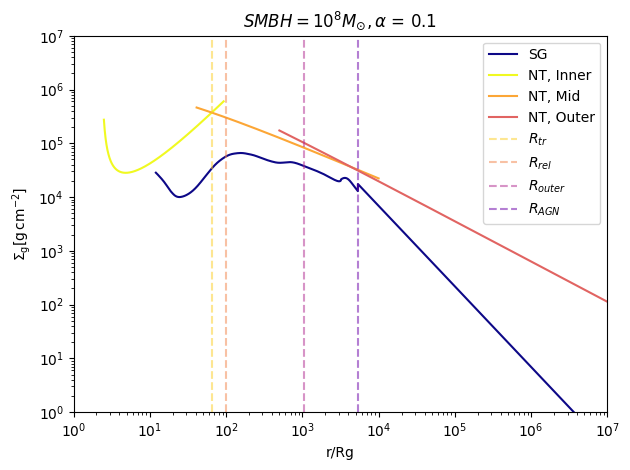

In [75]:
colour='plasma'
cmap = plt.colormaps[colour]

plt.plot(disk.R/R_G, 2*disk.h*disk.rho*ct.SI_to_gcm2, label = r"SG", color=cmap(0.0))
plt.ylabel(r'$\Sigma_{\rm g} [{\rm g \, cm}^{-2}]$')
plt.xlabel("r/Rg")

plt.xlim(1, 1e7)
plt.ylim(1, 1e7)
plt.xscale('log')
plt.yscale('log')

plt.plot(Rs, sigmas, '-', color=cmap(1.0), label = r"NT, Inner")
plt.plot(Rs_mid, sigmas_mid, '-', color=cmap(0.8), label = r"NT, Mid")
plt.plot(Rs_outer, sigmas_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=r_tr, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{tr}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=r_outer/R_G, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.2), alpha=0.5, label = r"$R_{AGN}$")


plt.legend()

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')

plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_SD_profiles_logMBH{MBH_power}_alpha{alpha}_2.pdf')
plt.show()

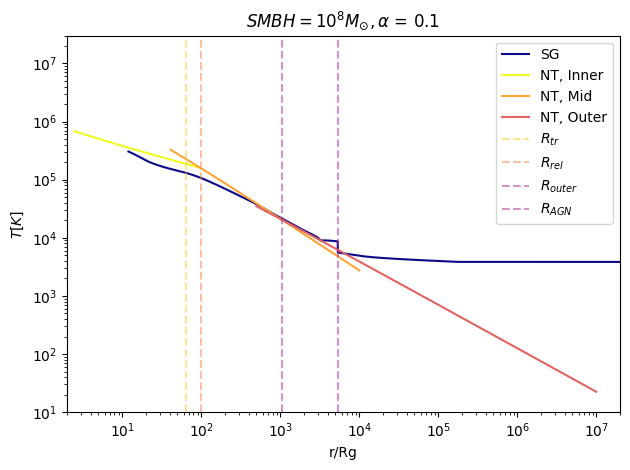

In [76]:

plt.plot(disk.R/R_G, disk.T, color=cmap(0.0), label = r"SG")
plt.ylabel(r'$T [K] $')
plt.xlabel("r/Rg")

plt.xscale('log')
plt.yscale('log')

plt.xlim(2, 2e7)
plt.ylim(1e1, 3e7)

plt.plot(Rs, Ts, '-', color=cmap(1.0), label = r"NT, Inner")
plt.plot(Rs_mid, Ts_mid, '-', color=cmap(0.8), label = r"NT, Mid")
plt.plot(Rs_outer, Ts_outer, '-', color=cmap(0.6), label = r"NT, Outer")

plt.axvline(x=r_tr, linestyle='--', color=cmap(0.9), alpha=0.5, label = r"$R_{tr}$")
plt.axvline(x=r_rel/R_G, linestyle='--', color=cmap(0.7), alpha=0.5, label = r"$R_{rel}$")
plt.axvline(x=r_outer/R_G, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{outer}$")
plt.axvline(x=disk.R_AGN/R_G, linestyle='--', color=cmap(0.4), alpha=0.5, label = r"$R_{AGN}$")

plt.title(f'$SMBH = 10^{MBH_power}'r'{M_{\odot}}, \alpha$ = 'f'{alpha}')
plt.legend()
plt.tight_layout()
plt.savefig(f'EMRIs_Jupiter_2/NT_vs_SG_T_profiles_logMBH{MBH_power}_alpha{alpha}.pdf')
plt.show()